# Projet de BIML 
## Sujet : 

In [12]:
import torch
import networkx as nx
import matplotlib.colors as mcolors

Avec lien : 


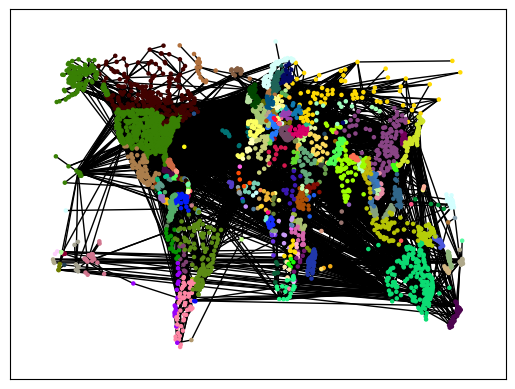

In [13]:
# Lecture du fichier
G = nx.read_graphml('dataset.graphml')

# Association des couleurs des noeuds en fonction du pays
unique_countries = list(set(G.nodes[node]["country"] for node in G.nodes))
colors_tab = dict(zip(unique_countries,mcolors.get_named_colors_mapping()))
node_colors = [colors_tab[G.nodes[node]["country"]] for node in G.nodes]

# Affichage du graphe avec les noeuds placés à leur position géographique
pos_map = {node: (G.nodes[node]["lon"], G.nodes[node]["lat"]) for node in G.nodes}
print("Avec lien : ")
graphml = nx.draw_networkx(G, pos=pos_map, with_labels=False, node_size=5, node_color=node_colors)

Sans lien : 


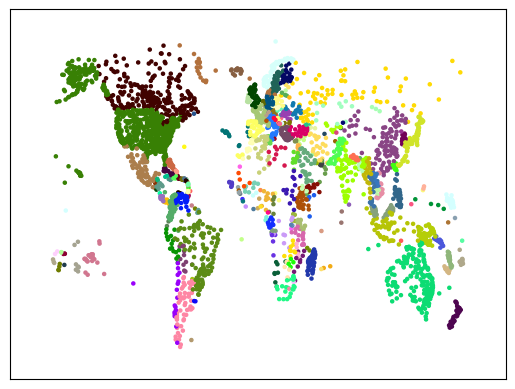

In [14]:
print("Sans lien : ")
graphml = nx.draw_networkx(G, pos=pos_map, with_labels=False, node_size=5, node_color=node_colors, edge_color='none')

## Entrainement sur toutes les données

In [15]:

import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
import torch.nn as nn

# Extraire les données de population et d'autres attributs pour chaque noeud
data = []
for node, attr in G.nodes(data=True):
    city_name = attr.get('city_name')
    country = attr.get('country')
    population = attr.get('population')
    lat = attr.get('lat')
    lon = attr.get('lon')
    
    # Ajouter les données à une liste ou un DataFrame pour l'analyse
    data.append([city_name, country, population, lat, lon])

# Transformer en DataFrame pour une manipulation plus simple
df = pd.DataFrame(data, columns=['City', 'Country', 'Population', 'Latitude', 'Longitude'])

# Encodage des noms de villes
# Encodage One-Hot des noms de villes et des pays
encoder = OneHotEncoder()
city_country_encoded = encoder.fit_transform(df[['City', 'Country']]).toarray()

# Normalisation des colonnes population, latitude et longitude
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Population', 'Latitude', 'Longitude']])

# Concatenation des données encodées et normalisées
X = np.hstack((city_country_encoded, scaled_data))
processed_data = torch.tensor(X, dtype=torch.float)

# Création d'un mappage des noeuds du graphe
node_map = {node: i for i, node in enumerate(G.nodes)}

# Obtention de l'index des arêtes depuis le graphe G
edges = [(node_map[u], node_map[v]) for u, v in G.edges]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Création d'un objet Data de PyTorch Geometric et division en train/test
data = Data(x=processed_data, edge_index=edge_index)
train_test = train_test_split_edges(data, test_ratio=0.1, val_ratio=0.05)
print(train_test)


c:\Users\tomhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[3363, 3503], val_pos_edge_index=[2, 677], test_pos_edge_index=[2, 1354], train_pos_edge_index=[2, 23032], train_neg_adj_mask=[3363, 3363], val_neg_edge_index=[2, 677], test_neg_edge_index=[2, 1354])


In [16]:
from torch_geometric.nn import GCNConv, VGAE

# Encoder pour le modèle VGAE
class Encoder(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(dim_in, 2 * dim_out)
        self.conv_mu = GCNConv(2 * dim_out, dim_out)
        self.conv_logstd = GCNConv(2 * dim_out, dim_out)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)
    

In [17]:
model = VGAE(Encoder(data.num_features, 16))

# Mise en place du modèle et des données sur le GPU si disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Fonctions d'entraînement et de test
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index) + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

def test(pos_edge_index, neg_edge_index, epoch):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
        val_auc, val_ap = model.test(z, pos_edge_index, neg_edge_index)
        if epoch % 10 == 0:
            # Affichage accuracy
            print(f'Epoch: {epoch:03d}, AUC: {val_auc:.4f}, AP: {val_ap:.4f}')
        
    return z

num_epochs = 200
print("Entraînement validation : ")
for epoch in range(num_epochs):
    loss = train()
    
    # Calcul des performances sur le jeu de validation
    z = test(train_test.val_pos_edge_index, train_test.val_neg_edge_index, epoch)
    
# Test final après les 200 epochs pour évaluer les performances
print("Test final : ")
z = test(train_test.test_pos_edge_index, train_test.test_neg_edge_index, num_epochs)

Entraînement validation : 
Epoch: 000, AUC: 0.8979, AP: 0.9064
Epoch: 010, AUC: 0.8940, AP: 0.9065
Epoch: 020, AUC: 0.8980, AP: 0.9143
Epoch: 030, AUC: 0.9057, AP: 0.9212
Epoch: 040, AUC: 0.9060, AP: 0.9233
Epoch: 050, AUC: 0.9025, AP: 0.9212
Epoch: 060, AUC: 0.9257, AP: 0.9376
Epoch: 070, AUC: 0.9283, AP: 0.9400
Epoch: 080, AUC: 0.9238, AP: 0.9392
Epoch: 090, AUC: 0.9258, AP: 0.9411
Epoch: 100, AUC: 0.9320, AP: 0.9442
Epoch: 110, AUC: 0.9324, AP: 0.9446
Epoch: 120, AUC: 0.9323, AP: 0.9447
Epoch: 130, AUC: 0.9325, AP: 0.9444
Epoch: 140, AUC: 0.9345, AP: 0.9458
Epoch: 150, AUC: 0.9358, AP: 0.9470
Epoch: 160, AUC: 0.9379, AP: 0.9489
Epoch: 170, AUC: 0.9426, AP: 0.9519
Epoch: 180, AUC: 0.9427, AP: 0.9528
Epoch: 190, AUC: 0.9473, AP: 0.9557
Test final : 
Epoch: 200, AUC: 0.9638, AP: 0.9686


In [18]:
# On crée un décodeur pour prédire la population
class PopulationDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(PopulationDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 1)
        self.act = nn.ReLU()

    def forward(self, z):
        return self.act(self.fc(z))

# Initialisation du décodeur
decoder = PopulationDecoder(z.size(1)).to(device)
decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=0.1)
criterion = nn.L1Loss()    

population_normalized = scaler.fit_transform(df[['Population']])
population_real = torch.tensor(population_normalized, dtype=torch.float32, device=device).unsqueeze(1)

# Entraînement du décodeur
def train_decoder():
    decoder.train()
    decoder_optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index) + (1 / data.num_nodes) * model.kl_loss()
    population_loss = criterion(decoder(z), population_real)
    total_loss = loss + population_loss
    total_loss.backward()
    decoder_optimizer.step()
    return float(total_loss)
        

# Entraîner le décodeur après avoir obtenu les embeddings latents du modèle VGAE
def test_decoder():
    decoder.eval()
    with torch.no_grad():
        predicted_population = decoder(z)
    return predicted_population

for epoch in range(100):
    loss = train_decoder()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
predicted_population = test_decoder()
    

c:\Users\tomhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([3363, 1, 1])) that is different to the input size (torch.Size([3363, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 000, Loss: 0.8656
Epoch: 010, Loss: 0.8371
Epoch: 020, Loss: 0.8359
Epoch: 030, Loss: 0.8345
Epoch: 040, Loss: 0.8400
Epoch: 050, Loss: 0.8425
Epoch: 060, Loss: 0.8348
Epoch: 070, Loss: 0.8359
Epoch: 080, Loss: 0.8369
Epoch: 090, Loss: 0.8401


Nous partons du principe que les données faussées sont celles étant égales à 10000. Nous allons donc maintenant faire une comparaison entre les données réelles et celle prédites par le modèle. 

In [19]:
# Dénormalisation des populations
predicted_population_denorm = scaler.inverse_transform(predicted_population.cpu().numpy())

# Calcul des écarts entre population réelle et prédite
population_real = df['Population'].values.reshape(-1, 1) 
print(population_real.shape)
print(predicted_population_denorm.shape)

threshold = 0.1 * np.mean(population_real)  # Seuil pour identifier les anomalies

outliers = np.abs(population_real - predicted_population_denorm) < threshold

# Obtenir les noms des villes suspectes
suspect_cities = df.iloc[outliers]['City'].values

for city in suspect_cities:
    print("Villes avec des anomalies de population: "+ city+ " - " + str(df[df['City'] == city]['Population'].values[0]) )


(3363, 1)
(3363, 1)
Villes avec des anomalies de population: Anaa - 10000
Villes avec des anomalies de population: Hao Island - 10000
Villes avec des anomalies de population: Papeete - 26357
Villes avec des anomalies de population: Gambier Island - 10000
Villes avec des anomalies de population: Makemo - 10000
Villes avec des anomalies de population: Atuona - 10000
Villes avec des anomalies de population: Bora Bora - 10000
Villes avec des anomalies de population: Huahine - 10000
Villes avec des anomalies de population: Easter Island - 10000
Villes avec des anomalies de population: Kaukura Atoll - 10000
Villes avec des anomalies de population: Moorea - 10000
Villes avec des anomalies de population: Nuku Hiva - 10000
Villes avec des anomalies de population: Noumea - 10000
Villes avec des anomalies de population: Mataiva - 10000
Villes avec des anomalies de population: Rarotonga - 10000
Villes avec des anomalies de population: Raiatea Island - 10000
Villes avec des anomalies de population:

In [20]:
# pourcentage de villes avec des anomalies
print(f'Pourcentage de villes avec des anomalies détectées: {len(suspect_cities) / len(df) * 100:.2f}%')

# pourcentage de villes avec anomalies de population = 10000
cpt = 0
for city in suspect_cities:
    cpt += 1 if df[df['City'] == city]['Population'].values[0] == 10000 else 0
print(f'Pourcentage de villes avec anomalies ayant 10000 de population: {cpt / len(df) * 100:.2f}%')

# pourcentage de ville avec 10000 habitants
print(f'Pourcentage de villes avec 10000 habitants: {len(df[df["Population"] == 10000]) / len(df) * 100:.2f}%')

Pourcentage de villes avec des anomalies détectées: 58.61%
Pourcentage de villes avec anomalies ayant 10000 de population: 49.72%
Pourcentage de villes avec 10000 habitants: 49.75%


Sans lien : 


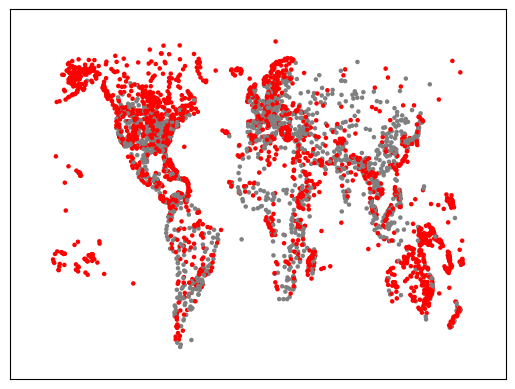

In [21]:
# Visualisation des anomalies
anomalous_nodes = [node_map[node] for node in G.nodes if G.nodes[node]['city_name'] in suspect_cities.tolist()]

node_colors = ['red' if node_map[node] in anomalous_nodes else 'grey' for node in G.nodes]

print("Sans lien : ")
graphml = nx.draw_networkx(G, pos=pos_map, with_labels=False, node_size=5, node_color=node_colors, edge_color='none')


In [22]:
#Enregistrement des anomalies dans un fichier texte
with open('anomalies_vgae.txt', 'w') as f:
    for city in suspect_cities:
        f.write(city+ " - " + str(df[df['City'] == city]['Population'].values[0]) + "\n")